In [1]:
from google.colab import files
uploaded = files.upload()


Saving Public_transport_Dataset.csv to Public_transport_Dataset.csv


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [5]:
data = pd.read_csv('Public_transport_Dataset.csv')



In [6]:
print(data.head())

         Date  Local Route  Light Rail  Peak Service  Rapid Route  School  \
0  30/08/2024        16436       10705           225        19026    3925   
1  15/09/2023        15499       10671           267        18421    4519   
2  28/12/2021         1756        2352             0         3775       0   
3  11/01/2023        10536        8347           223        14072       0   
4  11/09/2021          820         612             0         1283       0   

   Other  
0   59.0  
1   61.0  
2   13.0  
3   48.0  
4   11.0  


In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1918 non-null   object 
 1   Local Route   1918 non-null   int64  
 2   Light Rail    1918 non-null   int64  
 3   Peak Service  1918 non-null   int64  
 4   Rapid Route   1918 non-null   int64  
 5   School        1918 non-null   int64  
 6   Other         1898 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 105.0+ KB
None


In [9]:
data['Date'] = pd.to_datetime(data['Date'],dayfirst=True)

In [15]:
data.sort_index(ascending=True, inplace=True)

print(data.head())


            Local Route  Light Rail  Peak Service  Rapid Route  School  Other
Date                                                                         
2019-07-01        15987        9962           407        21223    3715   28.0
2019-07-02        16895       10656           409        21715    3993    2.0
2019-07-03        16613       10658           427        22025    3638    0.0
2019-07-04        16604       10445           437        21868    3576   82.0
2019-07-05        16040       10532           400        20697    2856    0.0


In [14]:
data.fillna(method='ffill', inplace=True)


<ipython-input-14-519281724d28>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [16]:
data.interpolate(method='time', inplace=True)

In [19]:
data.rename(columns={
    'Local Route': 'Local_Route',
    'Light Rail': 'Light_Rail',
    'Peak Service': 'Peak_Service',
    'Rapid Route': 'Rapid_Route',
    'School': 'School_Service',
    'Other' :'Other_services'
}, inplace=True)

In [22]:
print("First five rows after preprocessing:")
print(data.head())

First five rows after preprocessing:
            Local_Route  Light_Rail  Peak_Service  Rapid_Route  \
Date                                                             
2019-07-01        15987        9962           407        21223   
2019-07-02        16895       10656           409        21715   
2019-07-03        16613       10658           427        22025   
2019-07-04        16604       10445           437        21868   
2019-07-05        16040       10532           400        20697   

            School_Service  Other_services  
Date                                        
2019-07-01            3715            28.0  
2019-07-02            3993             2.0  
2019-07-03            3638             0.0  
2019-07-04            3576            82.0  
2019-07-05            2856             0.0  


In [29]:
target = 'Local_Route'
series = data[target]

In [30]:
train = series[:-7]
test = series[-7:]


In [45]:
train = np.log1p(train)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC (Akaike Information Criterion): 2571.29

Model Coefficients:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0936      0.024      3.830      0.000       0.046       0.142
ma.L1         -0.7398      0.019    -38.296      0.000      -0.778      -0.702
ar.S.L7       -0.4568      0.009    -51.717      0.000      -0.474      -0.439
sigma2         0.2264      0.002     96.510      0.000       0.222       0.231


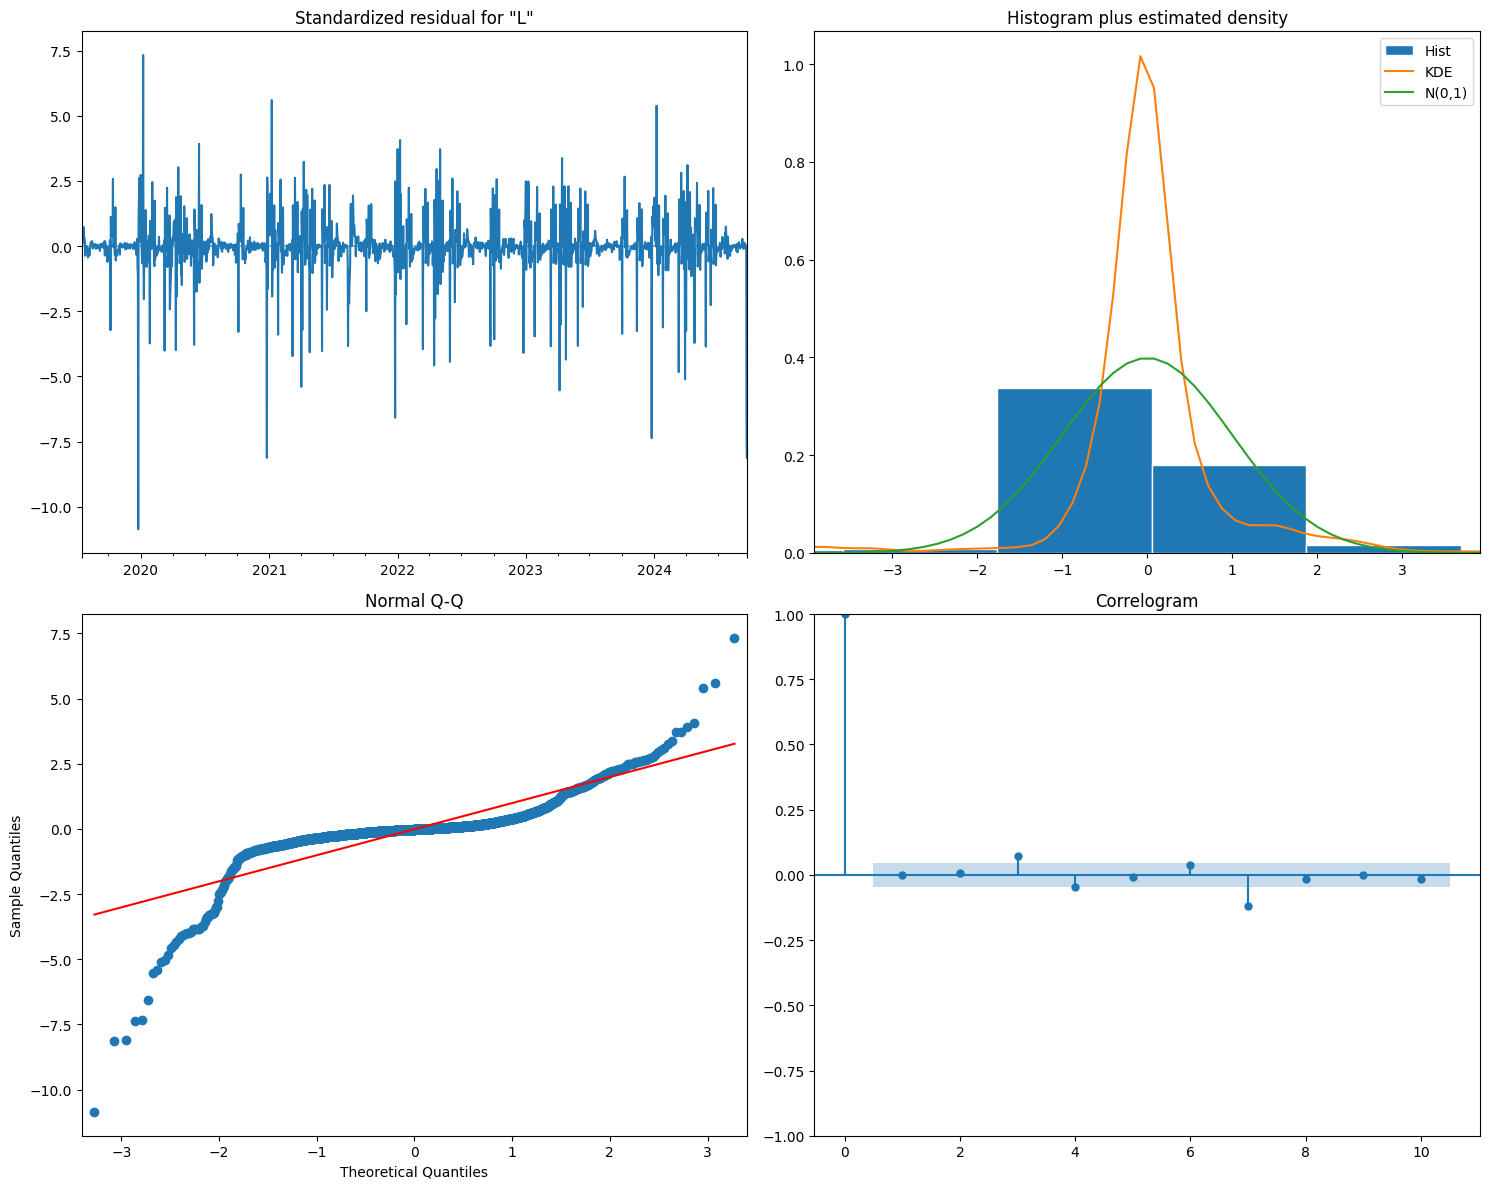

In [71]:
model = SARIMAX(train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 0, 7),
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit()

print(f"AIC (Akaike Information Criterion): {round(model_fit.aic, 2)}")

print("\nModel Coefficients:")
print(model_fit.summary().tables[1])


model_fit.plot_diagnostics(figsize=(15, 12))
plt.tight_layout()
plt.show()


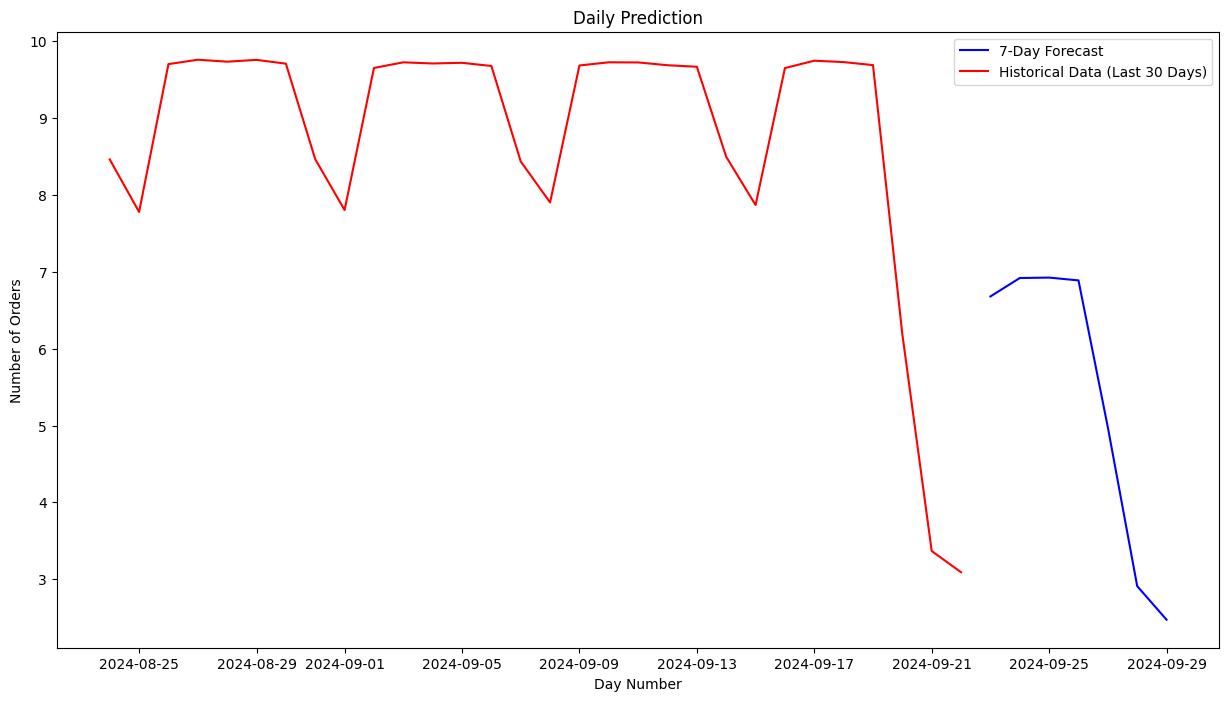

In [72]:
train_daily = train.resample('D').sum()


pred_uc = model_fit.get_forecast(steps=7)


plt.rcParams['figure.figsize'] = [15, 8]
plt.plot(pred_uc.predicted_mean, label='7-Day Forecast', color='blue')

plt.plot(train_daily[-30:], label='Historical Data (Last 30 Days)', color='red')

plt.xlabel('Day Number')
plt.ylabel('Number of Orders')
plt.title('Daily Prediction')
plt.legend()
plt.show()


In [75]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


test = series[-7:]
forecast = pred_uc.predicted_mean

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 778.5349805979785
RMSE: 1027.028661347839


Training model for: Light_Rail


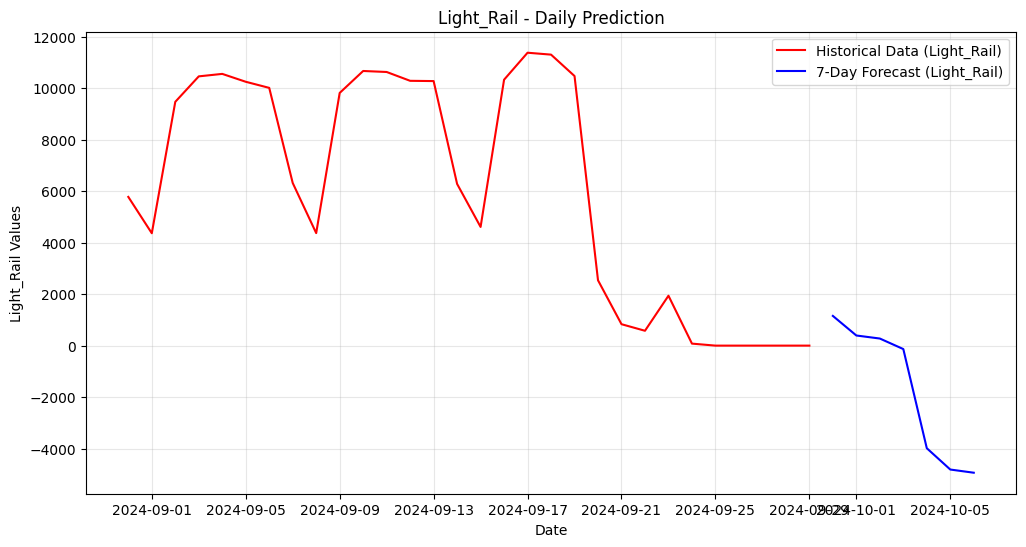

AIC for Light_Rail: 32932.29165893106
Training model for: Peak_Service


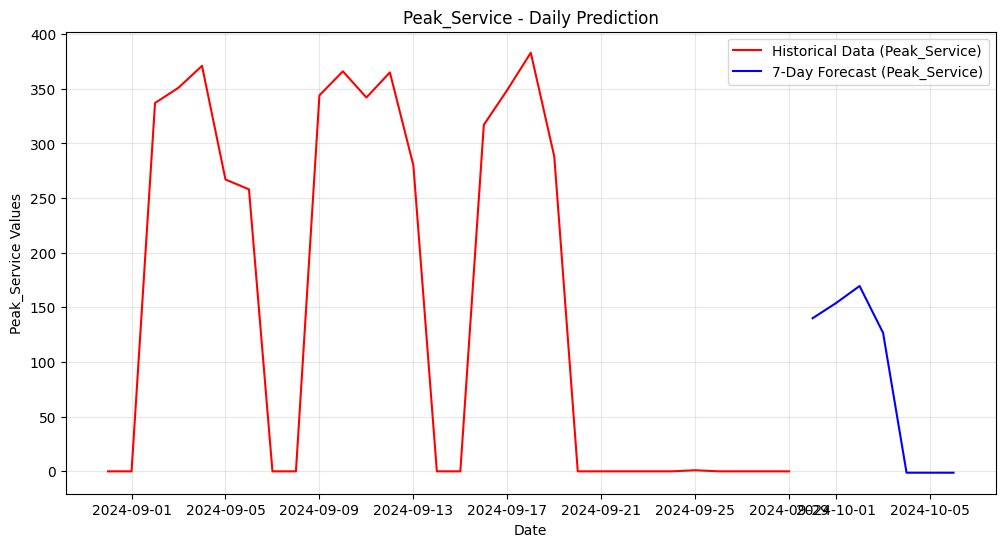

AIC for Peak_Service: 21549.750293086698
Training model for: Rapid_Route


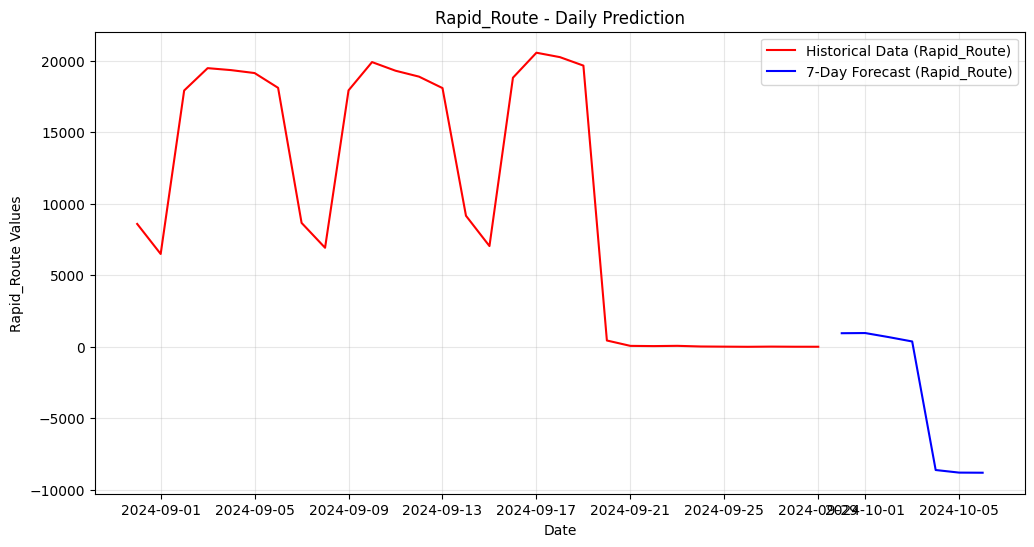

AIC for Rapid_Route: 35508.82854818858
Training model for: School_Service


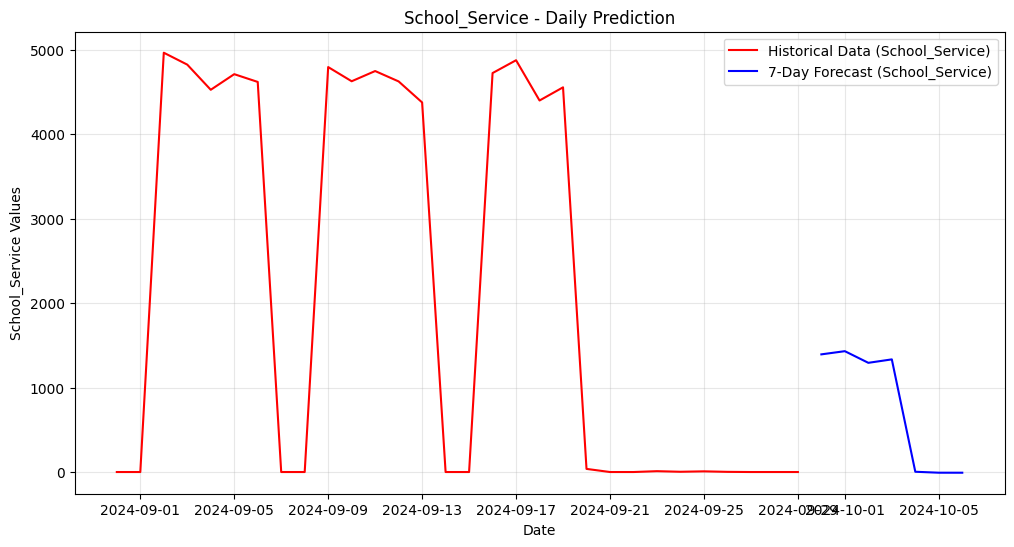

AIC for School_Service: 32931.189653967995

Forecast Results (7 Days):
             Light_Rail  Peak_Service  Rapid_Route  School_Service
2024-09-30  1153.800111    140.068965   948.519114     1393.796339
2024-10-01   393.146877    153.990818   960.753144     1431.555798
2024-10-02   275.158541    169.542999   676.959104     1293.523033
2024-10-03  -133.781727    126.731215   371.904432     1334.342820
2024-10-04 -3984.135833     -1.260270 -8611.480377        3.128516
2024-10-05 -4811.716496     -1.266173 -8792.828173       -8.090797
2024-10-06 -4935.488014     -1.268389 -8800.491131       -8.307562


In [76]:
labels = ['Light_Rail', 'Peak_Service', 'Rapid_Route', 'School_Service']

forecast_results = {}

for label in labels:
    print(f"Training model for: {label}")

    series = data[label].resample('D').sum()

    model = SARIMAX(series,
                    order=(1, 1, 1),
                    seasonal_order=(1, 1, 0, 7),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)

    pred_uc = model_fit.get_forecast(steps=7)
    forecast_results[label] = pred_uc.predicted_mean

    plt.figure(figsize=(12, 6))
    plt.plot(series[-30:], label=f'Historical Data ({label})', color='red')
    plt.plot(pred_uc.predicted_mean, label=f'7-Day Forecast ({label})', color='blue')
    plt.title(f'{label} - Daily Prediction')
    plt.xlabel('Date')
    plt.ylabel(f'{label} Values')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print(f"AIC for {label}: {model_fit.aic}")

forecast_df = pd.DataFrame(forecast_results)
print("\nForecast Results (7 Days):")
print(forecast_df)
